<a href="https://colab.research.google.com/github/sanagno/psychiatry-mri/blob/eeg/eeg_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.svm import SVC as svm
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,balanced_accuracy_score,f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from warnings import simplefilter
import autoencoder as ae
import importlib
importlib.reload(ae)
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


## Clean Data


In [0]:
behaviour_data=pd.read_csv("HBNFinalSummaries.csv",low_memory=False)

In [0]:
behaviour_data_id=behaviour_data.EID.values

In [311]:
len(behaviour_data)

2096

In [312]:
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1
            
# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0] for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases 
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col
    
initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size, 'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


In [313]:
behaviour_data.shape

(1777, 447)

In [314]:
no_diagnosis_given = 'No Diagnosis Given'
most_common_disorders

['Neurodevelopmental Disorders',
 'Anxiety Disorders',
 'Disruptive',
 'No Diagnosis Given',
 'Depressive Disorders',
 'Elimination Disorders']

In [0]:
classes = np.zeros((len(most_common_disorders), behaviour_data.shape[0]), dtype=np.int32)

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]
df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
            applymap(lambda x: disorder in x if pd.notnull(x) else False)
    
    disorder_df = df_disorders[mask.any(axis=1)]
    
    np.add.at(classes[i], disorder_df.index.values, 1)

In [0]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX')!=-1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [0]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

In [0]:
labels=behaviour_data[["EID"]+list(most_common_disorders)]

In [319]:
labels

,EID,Neurodevelopmental Disorders,Anxiety Disorders,Disruptive,No Diagnosis Given,Depressive Disorders,Elimination Disorders
0,NDARYM832PX3,1,1,0,0,0,0
1,NDARNJ687DMC,0,0,0,0,1,0
2,NDARRM363BXZ,1,0,0,0,0,0
3,NDARUW586LLL,0,0,0,0,1,0
4,NDARDC298NW4,1,0,0,0,0,0
...,...,...,...,...,...,...,...
1772,NDARJX939UCQ,1,0,1,0,0,0
1773,NDARJJ817UP1,1,0,0,0,0,0
1774,NDARYZ986HEW,1,1,1,0,0,0
1775,NDARPM572ZZV,1,0,0,0,0,0


## EEG Data


Electroencephalography (EEG) is an electrophysiological monitoring method to record electrical activity of the brain.

In [320]:
labels[no_diagnosis_given]=labels[no_diagnosis_given].apply(lambda x:0 if x==1 else 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
most_common_disorders=[disorder for disorder in most_common_disorders if disorder!=no_diagnosis_given]

In [322]:
most_common_disorders

['Neurodevelopmental Disorders',
 'Anxiety Disorders',
 'Disruptive',
 'Depressive Disorders',
 'Elimination Disorders']

In [323]:
eeg_mic=pd.read_csv("RestingEEG_Microstates.csv")
eeg_psd=pd.read_csv("RestingEEG_PSD_Average.csv")
eeg_spectro=pd.read_csv("RestingEEG_Spectro_Average.csv")

len(eeg_mic),len(eeg_psd),len(eeg_spectro)


(1108, 1485, 1485)

In [0]:
eeg_mic_labels=pd.merge(eeg_mic,labels,left_on='id',right_on='EID')
eeg_psd_labels=pd.merge(eeg_psd,labels,left_on='id',right_on='EID')
eeg_spectro_labels=pd.merge(eeg_spectro,labels,left_on='id',right_on='EID')

eeg_mic_labels.drop(columns=["EID"],inplace=True)
eeg_psd_labels.drop(columns=["EID"],inplace=True)
eeg_spectro_labels.drop(columns=["EID"],inplace=True)

In [325]:
labels_id=labels.EID.values
beh_full_id=behaviour_data_id.copy()

eeg_mic_id=eeg_mic.id.values

eeg_psd_id=eeg_psd.id.values

eeg_spectro_id=eeg_spectro.id.values

sum_=0
for id in eeg_mic_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)")
    
sum_=0
for id in eeg_mic_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).")
print()

sum_=0
for id in eeg_psd_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_psd_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).")
print()

sum_=0
for id in eeg_spectro_id:
  if id not in beh_full_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).")
    
sum_=0
for id in eeg_spectro_id:
  if id not in labels_id :
    sum_+=1
print("There are ",sum_,"mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .")






There are  135 mismatches between the Behavioral Data and the EEG_Mic Data. (Belong to EEG but not to Behavioral)
There are  158 mismatches between the Labels and the EEG_Mic Data (Belong to EEG and  but not to Labels).

There are  180 mismatches between the Behavioral Data and the EEG_PSD Data (Belong to EEG but not to Behavioral).
There are  208 mismatches between the Labels and the EEG_PSD Data (Belong to EEG but not to Labels).

There are  180 mismatches between the Behavioral Data and the EEG_Spectro Data (Belong to EEG but not to Behavioral).
There are  208 mismatches between the Labels and the EEG_Spectro Data (Belong to EEG but not to Labels) .


In [326]:
print("Microstate: {:5d} Subjects\nPSD: {:12d} Subjects\nSpectro: {:8d} Subjects".\
      format(len(eeg_mic_labels),len(eeg_psd_labels),len(eeg_spectro_labels)))



Microstate:   950 Subjects
PSD:         1277 Subjects
Spectro:     1277 Subjects


In [327]:
#Sanity check for set of EEG Feautures
if(len(set(eeg_mic_id).intersection(set(eeg_psd_id),set(eeg_spectro_id)))==len(eeg_mic_id) and \
   len(set(eeg_psd_id).intersection(set(eeg_spectro_id)))==len(eeg_psd_id)):
  print("Microstate, PSD and Spectro features contain the same subjects.")


Microstate, PSD and Spectro features contain the same subjects.


## Classification


In [0]:
def binary_classifier(x,y,conf_matrix=True,classifiers=['Logistic','Random Forest','SVM'],n_splits=5,C=20,\
                      return_result=True,verbose=False):

  
  skf=StratifiedKFold(n_splits=n_splits,shuffle=True)
  
  logistic='Logistic' in classifiers
  ranfor='Random Forest' in classifiers
  suve='SVM' in classifiers
  results={}
  
  if logistic:
    lgc=lg(C=C,class_weight='balanced',max_iter=1000,solver='lbfgs')
    y_pred_lgc=np.zeros(y.shape[0])
  if ranfor:
    rfc=rf(n_estimators=100,max_depth=5,class_weight='balanced')
    y_pred_rfc=np.zeros(y.shape[0])
  
  if suve:
    
    svmc=svm(C=C,class_weight='balanced')
    y_pred_svmc=np.zeros(y.shape[0])

  for train_index, test_index in skf.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if logistic:
          lgc.fit((x_train-x_train.mean())/x_train.std(), y_train)
          y_pred_lgc[test_index] = lgc.predict((x_test-x_train.mean())/x_train.std())
        if ranfor:
          rfc.fit(x_train, y_train)
          y_pred_rfc[test_index] = rfc.predict(x_test)
        if suve:
          svmc.fit((x_train-x_train.mean())/x_train.std(), y_train)
          y_pred_svmc[test_index] = svmc.predict((x_test-x_train.mean())/x_train.std())

  
  if logistic:
    acc=accuracy_score(y,y_pred_lgc)
    bacc=balanced_accuracy_score(y,y_pred_lgc)
    mr=f1_score(y,y_pred_lgc,average='weighted')
    cof_m=confusion_matrix(y,y_pred_lgc)
    if verbose:
      print("Logistic Regression")
      print("-------------------")
      print("Accuracy :",accuracy_score(y,y_pred_lgc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_lgc))
      print("f1-score :",f1_score(y,y_pred_lgc,average='weighted'))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_lgc))
      print()
    results['log']=[acc,bacc,mr,cof_m]
  if ranfor:
    acc=accuracy_score(y,y_pred_rfc)
    bacc=balanced_accuracy_score(y,y_pred_rfc)
    mr=f1_score(y,y_pred_rfc,average='weighted')
    cof_m=confusion_matrix(y,y_pred_rfc)
    if verbose:
      print("Random Forest")
      print("-----------------")
      print("Accuracy :",accuracy_score(y,y_pred_rfc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_rfc))
      print("f1-score :",f1_score(y,y_pred_rfc,average='macro'))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_rfc))
      print()
    results['rf']=[acc,bacc,mr,cof_m]

  if suve:
    acc=accuracy_score(y,y_pred_svmc)
    bacc=balanced_accuracy_score(y,y_pred_svmc)
    mr=f1_score(y,y_pred_svmc,average='weighted')
    cof_m=confusion_matrix(y,y_pred_svmc)
    if verbose:
      print("SVM")
      print("----------------")
      print("Accuracy :",accuracy_score(y,y_pred_svmc))
      print("Balanced Accuracy :",balanced_accuracy_score(y,y_pred_svmc))
      print("f1-score :",f1_score(y,y_pred_svmc,average='weighted'))
      if conf_matrix:
        print(confusion_matrix(y,y_pred_svmc))
    results['svm']=[acc,bacc,mr,cof_m]  
  print("Done")
  if return_result:
    return results    

 

In [0]:
def best_classifier(results):
  best={}
  for key_,value in results.items():
    best[key_]=sorted(value,key=lambda x:-x[1])[0]
  return best

def overall_best_result(results):
    best_per_disorder=best_classifier(results)
    results=[]
    for _,value in best_per_disorder.items():
      results.append(value[-1])

    return np.mean(results)



In [0]:
def best_per_disorder(raw,pca,ae):
  best={}
  raw_b=best_classifier(raw)
  pca_b=best_classifier(pca)
  ae_b=best_classifier(ae)
  for key in raw:
    score_raw=raw_b[key][-1]  
    score_pca=pca_b[key][-1]
    score_ae=ae_b[key][-1]
    max_=np.max([score_raw,score_pca,score_ae])
    max_index=np.argmax([score_raw,score_pca,score_ae])
    if max_index==0:
      method='raw'
    if max_index==1:
      method='pca'
    if max_index==2:
      method='ae'
    best[key]=(method,max_)
  return best

### EEG Microstates



EEG microstates are transient, patterned, quasi-stable states or patterns of an electroencephalogram. These tend to last anywhere from milliseconds to seconds and are hypothesized to be the most basic instantiations of human neurological tasks, and are thus nicknamed "the atoms of thought".

In [0]:
y_none=eeg_mic_labels[no_diagnosis_given].values==0
y=eeg_mic_labels[most_common_disorders]

In [0]:
x=eeg_mic_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])
x.fillna(x.mean(axis=0),inplace=True)


In [333]:
x.head()

,eyesclosed_microstates_gevtotal,eyesclosed_microstates_gfp_prototype1,eyesclosed_microstates_gfp_prototype2,eyesclosed_microstates_gfp_prototype3,eyesclosed_microstates_gfp_prototype4,eyesclosed_microstates_occurence_prototype1,eyesclosed_microstates_occurence_prototype2,eyesclosed_microstates_occurence_prototype3,eyesclosed_microstates_occurence_prototype4,eyesclosed_microstates_duration_prototype1,eyesclosed_microstates_duration_prototype2,eyesclosed_microstates_duration_prototype3,eyesclosed_microstates_duration_prototype4,eyesclosed_microstates_coverage_prototype1,eyesclosed_microstates_coverage_prototype2,eyesclosed_microstates_coverage_prototype3,eyesclosed_microstates_coverage_prototype4,eyesclosed_microstates_gev_prototype1,eyesclosed_microstates_gev_prototype2,eyesclosed_microstates_gev_prototype3,eyesclosed_microstates_gev_prototype4,eyesclosed_microstates_mspatcorr_prototype1,eyesclosed_microstates_mspatcorr_prototype2,eyesclosed_microstates_mspatcorr_prototype3,eyesclosed_microstates_mspatcorr_prototype4
0,0.815053,8.594640,7.840168,6.751696,6.155346,4.531579,3.605263,2.042105,1.826316,109.572590,74.712409,59.371134,61.798271,0.496537,0.269358,0.121242,0.112863,0.425801,0.179269,0.050128,0.033547,0.736561,0.707855,0.650813,0.648384
1,0.725810,7.300888,6.125996,5.441025,7.418961,3.929825,2.385965,0.745614,3.421053,118.696429,69.272059,58.470588,94.902564,0.466456,0.165281,0.043596,0.324667,0.305721,0.058535,0.007259,0.176843,0.702696,0.634576,0.491432,0.630921
2,0.727351,11.019322,10.683680,10.461474,10.210294,3.989474,3.515789,3.478947,2.773684,78.812665,71.227545,71.779123,66.857685,0.314421,0.250421,0.249716,0.185442,0.206668,0.148275,0.126315,0.082509,0.680067,0.669293,0.641487,0.608844
3,0.800499,6.234832,6.023094,4.939876,6.024174,3.563158,3.378947,1.710526,4.084211,74.824225,73.489097,66.381538,90.966495,0.266611,0.248316,0.113547,0.371526,0.196817,0.170259,0.045047,0.252637,0.730940,0.722275,0.659675,0.710730
4,0.770513,8.337967,7.112455,7.123003,6.603037,4.278947,2.389474,3.547368,2.057895,111.564576,62.334802,70.222552,60.531969,0.477379,0.148947,0.249105,0.124568,0.389897,0.074640,0.118653,0.044916,0.700755,0.657190,0.649427,0.616231


In [334]:
results_acc_1={}
results_bacc_1={}
results_f1_1={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  results_acc_1[disorder]=[]
  results_bacc_1[disorder]=[]
  results_f1_1[disorder]=[]
  for key,value in result.items():
      results_acc_1[disorder].append((key,value[0]))
      results_bacc_1[disorder].append((key,value[1]))
      results_f1_1[disorder].append((key,value[2]))

  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Done

=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Done

=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Done

=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Done

=============== Elimination Disorders ===================
Number of Subjects:  166
Positive:  41
Negative:  125

Done



#### PCA



In [0]:
x=(x-x.mean())/x.std()
pca=PCA().fit(x)

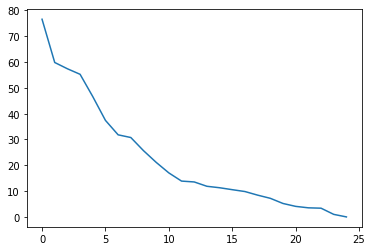

In [336]:
plt.plot(pca.singular_values_)

In [0]:
pca_x=pca.transform(x)[:,:12]

In [338]:
pca_results_acc_1={}
pca_results_bacc_1={}
pca_results_f1_1={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  pca_results_acc_1[disorder]=[]
  pca_results_bacc_1[disorder]=[]
  pca_results_f1_1[disorder]=[]
  for key,value in result.items():
      pca_results_acc_1[disorder].append((key,value[0]))
      pca_results_bacc_1[disorder].append((key,value[1]))
      pca_results_f1_1[disorder].append((key,value[2]))

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Done
=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Done
=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Done
=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Done
=============== Elimination Disorders ===================
Number of Subjects:  166
Positive:  41
Negative:  125

Done


#### Autoencoder

In [339]:
x=(x-x.mean())/x.std()
shape=x.shape[1]
layers=[50,25,25]
ae_=ae.Autoencoder(shape,layers=layers )
ae_.fit(x.values, print_every_epochs=1,log_path='micro')

reconstructed_data = ae_.reconstruct(x.values,log_path='micro')
loss=ae.get_reconstruction_loss(x.values,reconstructed_data)
print("Recostrunction Loss: ",loss)

x_encoding=ae_.encode_(x.values,log_path='micro')


INFO:tensorflow:Restoring parameters from micro/model-349
Recostrunction Loss:  1.0208966146276792
INFO:tensorflow:Restoring parameters from micro/model-349


In [340]:
ae_results_acc_1={}
ae_results_bacc_1={}
ae_results_f1_1={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x_encoding[y[disorder]==1],x_encoding[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  ae_results_acc_1[disorder]=[]
  ae_results_bacc_1[disorder]=[]
  ae_results_f1_1[disorder]=[]
  for key,value in result.items():
      ae_results_acc_1[disorder].append((key,value[0]))
      ae_results_bacc_1[disorder].append((key,value[1]))
      ae_results_f1_1[disorder].append((key,value[2]))

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Done
=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Done
=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Done
=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Done
=============== Elimination Disorders ===================
Number of Subjects:  166
Positive:  41
Negative:  125

Done


### EEG PSD




Power Spectral Densities (PSD): Frequency-wise spectral power from 1-90 Hz.

In [0]:
y_none=eeg_psd_labels[no_diagnosis_given].values==0
y=eeg_psd_labels[most_common_disorders]

In [0]:
x=eeg_psd_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])

#x.fillna(x.mean(axis=0),inplace=True) No missing values


In [343]:
x.head()

,eyesclosed_psd_01dot00hz_average,eyesclosed_psd_01dot50hz_average,eyesclosed_psd_02dot00hz_average,eyesclosed_psd_02dot50hz_average,eyesclosed_psd_03dot00hz_average,eyesclosed_psd_03dot50hz_average,eyesclosed_psd_04dot00hz_average,eyesclosed_psd_04dot50hz_average,eyesclosed_psd_05dot00hz_average,eyesclosed_psd_05dot50hz_average,eyesclosed_psd_06dot00hz_average,eyesclosed_psd_06dot50hz_average,eyesclosed_psd_07dot00hz_average,eyesclosed_psd_07dot50hz_average,eyesclosed_psd_08dot00hz_average,eyesclosed_psd_08dot50hz_average,eyesclosed_psd_09dot00hz_average,eyesclosed_psd_09dot50hz_average,eyesclosed_psd_10dot00hz_average,eyesclosed_psd_10dot50hz_average,eyesclosed_psd_11dot00hz_average,eyesclosed_psd_11dot50hz_average,eyesclosed_psd_12dot00hz_average,eyesclosed_psd_12dot50hz_average,eyesclosed_psd_13dot00hz_average,eyesclosed_psd_13dot50hz_average,eyesclosed_psd_14dot00hz_average,eyesclosed_psd_14dot50hz_average,eyesclosed_psd_15dot00hz_average,eyesclosed_psd_15dot50hz_average,eyesclosed_psd_16dot00hz_average,eyesclosed_psd_16dot50hz_average,eyesclosed_psd_17dot00hz_average,eyesclosed_psd_17dot50hz_average,eyesclosed_psd_18dot00hz_average,eyesclosed_psd_18dot50hz_average,eyesclosed_psd_19dot00hz_average,eyesclosed_psd_19dot50hz_average,eyesclosed_psd_20dot00hz_average,eyesclosed_psd_20dot50hz_average,...,eyesopen_psd_70dot50hz_average,eyesopen_psd_71dot00hz_average,eyesopen_psd_71dot50hz_average,eyesopen_psd_72dot00hz_average,eyesopen_psd_72dot50hz_average,eyesopen_psd_73dot00hz_average,eyesopen_psd_73dot50hz_average,eyesopen_psd_74dot00hz_average,eyesopen_psd_74dot50hz_average,eyesopen_psd_75dot00hz_average,eyesopen_psd_75dot50hz_average,eyesopen_psd_76dot00hz_average,eyesopen_psd_76dot50hz_average,eyesopen_psd_77dot00hz_average,eyesopen_psd_77dot50hz_average,eyesopen_psd_78dot00hz_average,eyesopen_psd_78dot50hz_average,eyesopen_psd_79dot00hz_average,eyesopen_psd_79dot50hz_average,eyesopen_psd_80dot00hz_average,eyesopen_psd_80dot50hz_average,eyesopen_psd_81dot00hz_average,eyesopen_psd_81dot50hz_average,eyesopen_psd_82dot00hz_average,eyesopen_psd_82dot50hz_average,eyesopen_psd_83dot00hz_average,eyesopen_psd_83dot50hz_average,eyesopen_psd_84dot00hz_average,eyesopen_psd_84dot50hz_average,eyesopen_psd_85dot00hz_average,eyesopen_psd_85dot50hz_average,eyesopen_psd_86dot00hz_average,eyesopen_psd_86dot50hz_average,eyesopen_psd_87dot00hz_average,eyesopen_psd_87dot50hz_average,eyesopen_psd_88dot00hz_average,eyesopen_psd_88dot50hz_average,eyesopen_psd_89dot00hz_average,eyesopen_psd_89dot50hz_average,eyesopen_psd_90dot00hz_average
0,13.252075,13.171060,10.303562,7.247638,5.177531,4.012201,3.257799,2.716654,2.334777,2.064073,1.951010,2.106707,2.599794,3.398925,5.155590,8.938139,12.533943,11.535839,6.956389,3.230759,1.504203,0.841712,0.597280,0.486366,0.416022,0.391247,0.391266,0.386449,0.366163,0.334611,0.294511,0.267583,0.273096,0.293408,0.299024,0.292122,0.284493,0.257461,0.204511,0.160624,...,0.041974,0.041617,0.038385,0.034233,0.032711,0.033877,0.034532,0.033885,0.033288,0.033455,0.033305,0.032292,0.031645,0.033093,0.035101,0.034616,0.033599,0.034358,0.034409,0.032573,0.030488,0.029183,0.029474,0.031485,0.032308,0.030559,0.028891,0.028484,0.028546,0.028926,0.030418,0.032051,0.030983,0.028301,0.028747,0.031572,0.032276,0.031815,0.030898,0.024803
1,18.933153,16.288860,10.595218,6.793446,5.170341,4.259245,3.492614,2.900088,2.419868,2.061413,1.849428,1.643705,1.433840,1.284499,1.148665,0.957932,0.774339,0.713294,0.722093,0.685296,0.611052,0.538792,0.473819,0.421145,0.378297,0.333074,0.284930,0.253142,0.256997,0.264753,0.252979,0.235653,0.220426,0.207347,0.197353,0.196580,0.201940,0.198415,0.186404,0.174339,...,0.017367,0.017632,0.018009,0.017191,0.016044,0.015546,0.015629,0.016328,0.017420,0.018440,0.019046,0.019026,0.018132,0.017376,0.016868,0.016151,0.016245,0.018334,0.020296,0.019596,0.017474,0.015387,0.014524,0.015458,0.017637,0.018725,0.017394,0.015399,0.013978,0.013282,0.013946,0.014787,0.014436,0.013733,0.013491,0.013280,0.012857,0.

In [344]:
results_acc_2={}
results_bacc_2={}
results_f1_2={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  results_acc_2[disorder]=[]
  results_bacc_2[disorder]=[]
  results_f1_2[disorder]=[]
  for key,value in result.items():
      results_acc_2[disorder].append((key,value[0]))
      results_bacc_2[disorder].append((key,value[1]))
      results_f1_2[disorder].append((key,value[2]))
  print()

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done

=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done

=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Done

=============== Depressive Disorders ===================
Number of Subjects:  285
Positive:  114
Negative:  171

Done

=============== Elimination Disorders ===================
Number of Subjects:  228
Positive:  57
Negative:  171

Done



#### PCA


In [0]:
x=(x-x.mean())/x.std()
pca=PCA().fit(x)


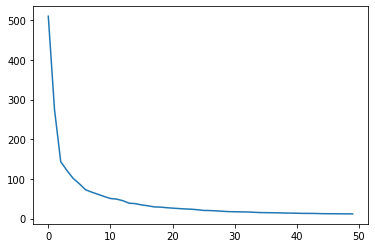

In [346]:
plt.plot(pca.singular_values_[:50])

In [0]:
pca_x=pca.transform(x)[:,:10]

In [348]:
pca_results_acc_2={}
pca_results_bacc_2={}
pca_results_f1_2={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  pca_results_acc_2[disorder]=[]
  pca_results_bacc_2[disorder]=[]
  pca_results_f1_2[disorder]=[]
  for key,value in result.items():
      pca_results_acc_2[disorder].append((key,value[0]))
      pca_results_bacc_2[disorder].append((key,value[1]))
      pca_results_f1_2[disorder].append((key,value[2]))

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Done
=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Done
=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Done
=============== Depressive Disorders ===================
Number of Subjects:  285
Positive:  114
Negative:  171

Done
=============== Elimination Disorders ===================
Number of Subjects:  228
Positive:  57
Negative:  171

Done


#### Autoencoder

In [349]:
x=(x-x.mean())/x.std()
shape=x.shape[1]
layers=[100,50,50]
ae_=ae.Autoencoder(shape,layers=layers )
ae_.fit(x.values, print_every_epochs=1,log_path='psd')

reconstructed_data = ae_.reconstruct(x.values,log_path='psd')
loss=ae.get_reconstruction_loss(x.values,reconstructed_data)
print("Recostrunction Loss: ",loss)

x_encoding=ae_.encode_(x.values,log_path='psd')

ae_results_acc_2={}
ae_results_bacc_2={}
ae_results_f1_2={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x_encoding[y[disorder]==1],x_encoding[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  ae_results_acc_2[disorder]=[]
  ae_results_bacc_2[disorder]=[]
  ae_results_f1_2[disorder]=[]
  for key,value in result.items():
      ae_results_acc_2[disorder].append((key,value[0]))
      ae_results_bacc_2[disorder].append((key,value[1]))
      ae_results_f1_2[disorder].append((key,value[2]))

INFO:tensorflow:Restoring parameters from psd/model-349
Recostrunction Loss:  0.9881613744127195
INFO:tensorflow:Restoring parameters from psd/model-349
=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Done
=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Done
=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Done
=============== Depressive Disorders ===================
Number of Subjects:  285
Positive:  114
Negative:  171

Done
=============== Elimination Disorders ===================
Number of Subjects:  228
Positive:  57
Negative:  171

Done


### EEG Spectro




Spectrogram-based features, such as frequency band, individual alpha power, and FOOOF parameters.



In [0]:
y_none=eeg_spectro_labels[no_diagnosis_given].values==0
y=eeg_spectro_labels[most_common_disorders]

In [0]:
x=eeg_spectro_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])

In [352]:
x.shape

(1277, 60)

In [353]:
# proportion of missing values per column with missing values
missing=sum(x.isnull().values)/x.shape[0]
for id,column in enumerate(x.columns.values):
  if (missing[id]>0):
    print(column,": ",missing[id])

eyesclosed_alphapeak_max_freq :  0.16836335160532498
eyesclosed_alphapeak_max_amplitude :  0.16836335160532498
eyesclosed_alphapeak_derivative_freq :  0.1581832419733751
eyesclosed_alphapeak_derivative_amplitude :  0.1581832419733751
eyesclosed_fooof_peak_freq_average :  0.0031323414252153485
eyesclosed_fooof_peak_amplitude_average :  0.0031323414252153485
eyesopen_alphapeak_max_freq :  0.33046202036021927
eyesopen_alphapeak_max_amplitude :  0.33046202036021927
eyesopen_alphapeak_derivative_freq :  0.2725137039937353
eyesopen_alphapeak_derivative_amplitude :  0.2725137039937353
eyesopen_fooof_peak_freq_average :  0.004698512137823023
eyesopen_fooof_peak_amplitude_average :  0.004698512137823023


In [0]:
x=x.drop(columns=x.columns[missing>0.2])
x.fillna(x.mean(),inplace=True)

In [355]:
results_acc_3={}
results_bacc_3={}
results_f1_3={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  results_acc_3[disorder]=[]
  results_bacc_3[disorder]=[]
  results_f1_3[disorder]=[]
  for key,value in result.items():
      results_acc_3[disorder].append((key,value[0]))
      results_bacc_3[disorder].append((key,value[1]))
      results_f1_3[disorder].append((key,value[2]))


=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Done
=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Done
=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Done
=============== Depressive Disorders ===================
Number of Subjects:  285
Positive:  114
Negative:  171

Done
=============== Elimination Disorders ===================
Number of Subjects:  228
Positive:  57
Negative:  171

Done


#### PCA


In [0]:
x=(x-x.mean())/x.std()

In [0]:
pca=PCA().fit(x)

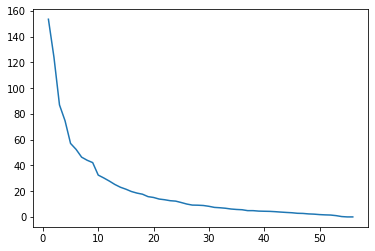

In [358]:
plt.plot(range(1,len(pca.singular_values_[:100])+1),pca.singular_values_[:100])

In [0]:
pca_x=pca.transform(x)[:,:30]

In [360]:
pca_results_acc_3={}
pca_results_bacc_3={}
pca_results_f1_3={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  pca_results_acc_3[disorder]=[]
  pca_results_bacc_3[disorder]=[]
  pca_results_f1_3[disorder]=[]
  for key,value in result.items():
      pca_results_acc_3[disorder].append((key,value[0]))
      pca_results_bacc_3[disorder].append((key,value[1]))
      pca_results_f1_3[disorder].append((key,value[2]))

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Done
=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Done
=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Done
=============== Depressive Disorders ===================
Number of Subjects:  285
Positive:  114
Negative:  171

Done
=============== Elimination Disorders ===================
Number of Subjects:  228
Positive:  57
Negative:  171

Done


#### Autoencoder


In [361]:
x=(x-x.mean())/x.std()
shape=x.shape[1]
layers=[50,30,30]
ae_=ae.Autoencoder(shape,layers=layers )
ae_.fit(x.values, print_every_epochs=1,log_path='spectro')

reconstructed_data = ae_.reconstruct(x.values,log_path='spectro')
loss=ae.get_reconstruction_loss(x.values,reconstructed_data)
print("Recostrunction Loss: ",loss)

x_encoding=ae_.encode_(x.values,log_path='spectro')

ae_results_acc_3={}
ae_results_bacc_3={}
ae_results_f1_3={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x_encoding[y[disorder]==1],x_encoding[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  ae_results_acc_3[disorder]=[]
  ae_results_bacc_3[disorder]=[]
  ae_results_f1_3[disorder]=[]
  for key,value in result.items():
      ae_results_acc_3[disorder].append((key,value[0]))
      ae_results_bacc_3[disorder].append((key,value[1]))
      ae_results_f1_3[disorder].append((key,value[2]))

INFO:tensorflow:Restoring parameters from spectro/model-349
Recostrunction Loss:  1.0113215802669886
INFO:tensorflow:Restoring parameters from spectro/model-349
=============== Neurodevelopmental Disorders ===================
Number of Subjects:  1111
Positive:  940
Negative:  171

Done
=============== Anxiety Disorders ===================
Number of Subjects:  472
Positive:  301
Negative:  171

Done
=============== Disruptive ===================
Number of Subjects:  374
Positive:  203
Negative:  171

Done
=============== Depressive Disorders ===================
Number of Subjects:  285
Positive:  114
Negative:  171

Done
=============== Elimination Disorders ===================
Number of Subjects:  228
Positive:  57
Negative:  171

Done


### All together

In [0]:
all=eeg_mic.merge(eeg_psd,how='inner',on='id')
all=all.merge(eeg_spectro,how='inner',on='id')
all_labels=all.merge(labels,how='inner',left_on='id',right_on='EID')

In [0]:
y_none=all_labels[no_diagnosis_given]==0
y=all_labels[most_common_disorders]
x=all_labels.drop(columns=["id"]+list(most_common_disorders)+[no_diagnosis_given])

x.drop(columns=["EID"],inplace=True)


In [0]:
missing=sum(x.isnull().values)/x.shape[0]
x=x.drop(columns=x.columns[missing>0.2])
x.fillna(x.mean(),inplace=True)

In [365]:
results_acc_all={}
results_bacc_all={}
results_f1_all={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x[y[disorder]==1].values,x[y_none].values),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  results_acc_all[disorder]=[]
  results_bacc_all[disorder]=[]
  results_f1_all[disorder]=[]
  for key,value in result.items():
      results_acc_all[disorder].append((key,value[0]))
      results_bacc_all[disorder].append((key,value[1]))
      results_f1_all[disorder].append((key,value[2]))



=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Done
=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Done
=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Done
=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Done
=============== Elimination Disorders ===================
Number of Subjects:  166
Positive:  41
Negative:  125

Done


#### PCA


In [0]:
##PCA
x=(x-x.mean())/x.std()
pca=PCA().fit(x)


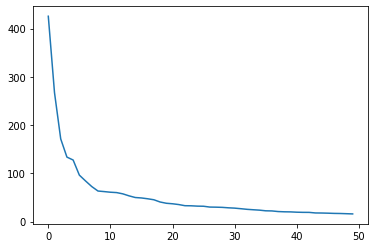

In [367]:
import matplotlib.pyplot as plt
plt.plot(pca.singular_values_[:50])

In [0]:
pca_x=pca.transform(x)[:,:20]

In [369]:
pca_results_acc_all={}
pca_results_bacc_all={}
pca_results_f1_all={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((pca_x[y[disorder]==1],pca_x[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  pca_results_acc_all[disorder]=[]
  pca_results_bacc_all[disorder]=[]
  pca_results_f1_all[disorder]=[]
  for key,value in result.items():
      pca_results_acc_all[disorder].append((key,value[0]))
      pca_results_bacc_all[disorder].append((key,value[1]))
      pca_results_f1_all[disorder].append((key,value[2]))

=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Done
=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Done
=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Done
=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Done
=============== Elimination Disorders ===================
Number of Subjects:  166
Positive:  41
Negative:  125

Done


#### Autoencoder

In [370]:
x=(x-x.mean())/x.std()
shape=x.shape[1]
layers=[100,50,50]
ae_=ae.Autoencoder(shape,layers=layers )
ae_.fit(x.values, print_every_epochs=1,log_path='Auto_all')

reconstructed_data = ae_.reconstruct(x.values,log_path='Auto_all')
loss=ae.get_reconstruction_loss(x.values,reconstructed_data)
print("Recostrunction Loss: ",loss)

x_encoding=ae_.encode_(x.values,log_path='Auto_all')

ae_results_acc_all={}
ae_results_bacc_all={}
ae_results_f1_all={}
for disorder in y.columns.values:
  print("===============",disorder,"===================")
  x_=np.concatenate((x_encoding[y[disorder]==1],x_encoding[y_none]),axis=0)
  y_=np.concatenate((np.ones(sum(y[disorder].values==1)),np.zeros(sum(y_none))),axis=0)
  print("Number of Subjects: ",y_.shape[0])
  print("Positive: ",sum(y_==1))
  print("Negative: ",sum(y_==0))
  print()
  result=binary_classifier(x_,y_)
  
  ae_results_acc_all[disorder]=[]
  ae_results_bacc_all[disorder]=[]
  ae_results_f1_all[disorder]=[]
  for key,value in result.items():
      ae_results_acc_all[disorder].append((key,value[0]))
      ae_results_bacc_all[disorder].append((key,value[1]))
      ae_results_f1_all[disorder].append((key,value[2]))


INFO:tensorflow:Restoring parameters from Auto_all/model-349
Recostrunction Loss:  0.9835133866454691
INFO:tensorflow:Restoring parameters from Auto_all/model-349
=============== Neurodevelopmental Disorders ===================
Number of Subjects:  829
Positive:  704
Negative:  125

Done
=============== Anxiety Disorders ===================
Number of Subjects:  338
Positive:  213
Negative:  125

Done
=============== Disruptive ===================
Number of Subjects:  277
Positive:  152
Negative:  125

Done
=============== Depressive Disorders ===================
Number of Subjects:  213
Positive:  88
Negative:  125

Done
=============== Elimination Disorders ===================
Number of Subjects:  166
Positive:  41
Negative:  125

Done


## Results





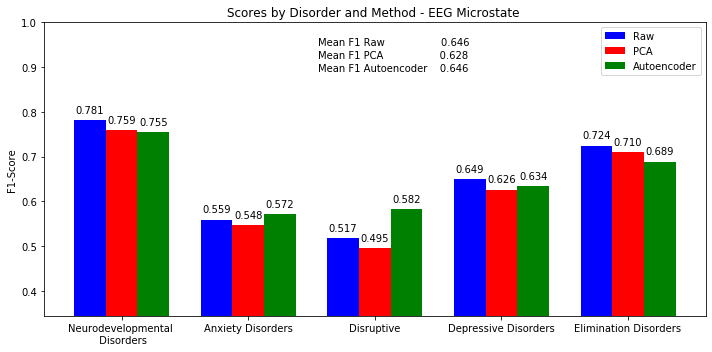

In [371]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
best_1=best_classifier(results_f1_1)
best_1=[value[-1] for _,value in best_1.items()]

best_1_pca=best_classifier(pca_results_f1_1)
best_1_pca=[value[-1] for _,value in best_1_pca.items()]

best_1_ae=best_classifier(ae_results_f1_1)
best_1_ae=[value[-1] for _,value in best_1_ae.items()]

labels=['Neurodevelopmental \n Disorders','Anxiety Disorders','Disruptive','Depressive Disorders','Elimination Disorders']


x = np.arange(len(labels))  # the label locations
width = 1/(3+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x , best_1, width, label='Raw',color='b')
rects2 = ax.bar(x+ width , best_1_pca, width, label='PCA',color='r')
rects3 = ax.bar(x + 2*width, best_1_ae, width, label='Autoencoder',color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Scores by Disorder and Method - EEG Microstate ')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

ax.annotate('{:28} {:.3f}'.format('Mean F1 Raw',np.mean(best_1)),xy=(len(x)/2-0.7,0.95))
ax.annotate('{:28} {:.3f}'.format('Mean F1 PCA',np.mean(best_1_pca)),xy=(len(x)/2-0.7,0.92))
ax.annotate('{:22} {:.3f}'.format("Mean F1 Autoencoder",np.mean(best_1_ae)),xy=(len(x)/2-0.7,0.89))
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.ylim([np.min(best_all) - (1 - np.min(best_all)) / 2, 1])



fig.tight_layout()


plt.show()

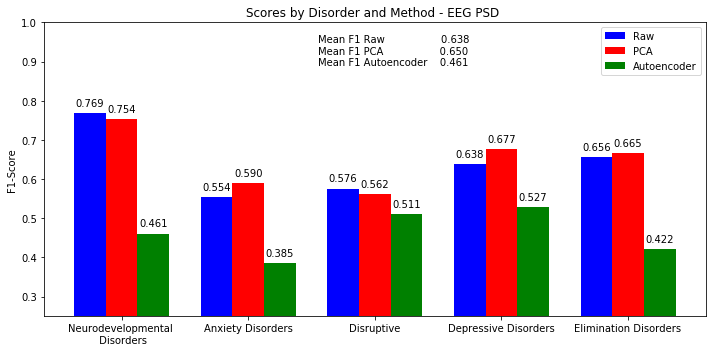

In [372]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
best_2=best_classifier(results_f1_2)
best_2=[value[-1] for _,value in best_2.items()]

best_2_pca=best_classifier(pca_results_f1_2)
best_2_pca=[value[-1] for _,value in best_2_pca.items()]

best_2_ae=best_classifier(ae_results_f1_2)
best_2_ae=[value[-1] for _,value in best_2_ae.items()]

labels=['Neurodevelopmental \n Disorders','Anxiety Disorders','Disruptive','Depressive Disorders','Elimination Disorders']


x = np.arange(len(labels))  # the label locations
width = 1/(3+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x , best_2, width, label='Raw',color='b')
rects2 = ax.bar(x+ width , best_2_pca, width, label='PCA',color='r')
rects3 = ax.bar(x + 2*width, best_2_ae, width, label='Autoencoder',color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Scores by Disorder and Method - EEG PSD ')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

ax.annotate('{:28} {:.3f}'.format('Mean F1 Raw',np.mean(best_2)),xy=(len(x)/2-0.7,0.95))
ax.annotate('{:28} {:.3f}'.format('Mean F1 PCA',np.mean(best_2_pca)),xy=(len(x)/2-0.7,0.92))
ax.annotate('{:22} {:.3f}'.format("Mean F1 Autoencoder",np.mean(best_2_ae)),xy=(len(x)/2-0.7,0.89))
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.ylim([0.5 - (1 - 0.5) / 2, 1])



fig.tight_layout()


plt.show()

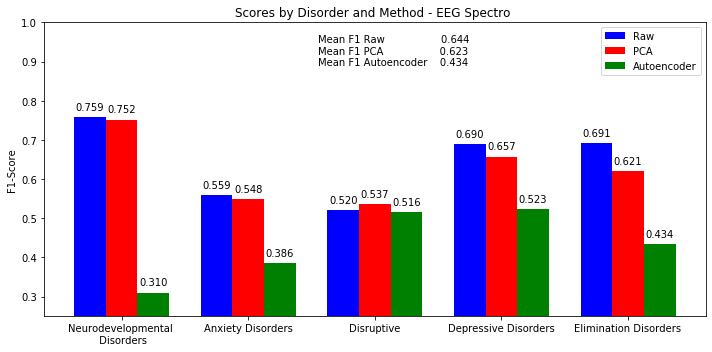

In [378]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
best_3=best_classifier(results_f1_3)
best_3=[value[-1] for _,value in best_3.items()]

best_3_pca=best_classifier(pca_results_f1_3)
best_3_pca=[value[-1] for _,value in best_3_pca.items()]

best_3_ae=best_classifier(ae_results_f1_3)
best_3_ae=[value[-1] for _,value in best_3_ae.items()]

labels=['Neurodevelopmental \n Disorders','Anxiety Disorders','Disruptive','Depressive Disorders','Elimination Disorders']


x = np.arange(len(labels))  # the label locations
width = 1/(3+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x , best_3, width, label='Raw',color='b')
rects2 = ax.bar(x+ width , best_3_pca, width, label='PCA',color='r')
rects3 = ax.bar(x + 2*width, best_3_ae, width, label='Autoencoder',color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Scores by Disorder and Method - EEG Spectro ')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

ax.annotate('{:28} {:.3f}'.format('Mean F1 Raw',np.mean(best_3)),xy=(len(x)/2-0.7,0.95))
ax.annotate('{:28} {:.3f}'.format('Mean F1 PCA',np.mean(best_3_pca)),xy=(len(x)/2-0.7,0.92))
ax.annotate('{:22} {:.3f}'.format("Mean F1 Autoencoder",np.mean(best_3_ae)),xy=(len(x)/2-0.7,0.89))
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.ylim([0.5 - (1 - 0.5) / 2, 1])



fig.tight_layout()


plt.show()

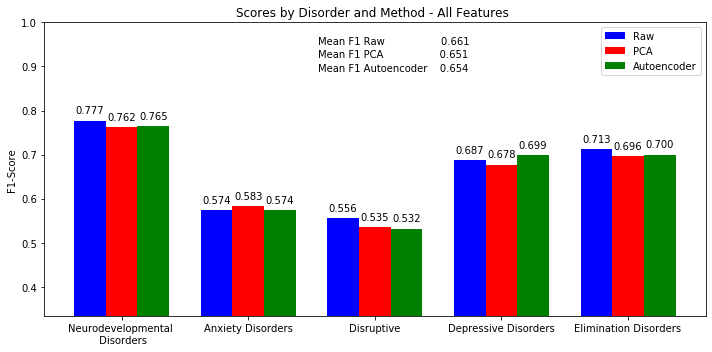

In [374]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
best_all=best_classifier(results_f1_all)
best_all=[value[-1] for _,value in best_all.items()]

best_all_pca=best_classifier(pca_results_f1_all)
best_all_pca=[value[-1] for _,value in best_all_pca.items()]

best_all_ae=best_classifier(ae_results_f1_all)
best_all_ae=[value[-1] for _,value in best_all_ae.items()]


labels=['Neurodevelopmental \n Disorders','Anxiety Disorders','Disruptive','Depressive Disorders','Elimination Disorders']

x = np.arange(len(labels))  # the label locations
width = 1/(3+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x , best_all, width, label='Raw',color='b')
rects2 = ax.bar(x+ width , best_all_pca, width, label='PCA',color='r')
rects3 = ax.bar(x + 2*width, best_all_ae, width, label='Autoencoder',color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Scores by Disorder and Method - All Features ')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

ax.annotate('{:28} {:.3f}'.format('Mean F1 Raw',np.mean(best_all)),xy=(len(x)/2-0.7,0.95))
ax.annotate('{:28} {:.3f}'.format('Mean F1 PCA',np.mean(best_all_pca)),xy=(len(x)/2-0.7,0.92))
ax.annotate('{:22} {:.3f}'.format("Mean F1 Autoencoder",np.mean(best_all_ae)),xy=(len(x)/2-0.7,0.89))
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.ylim([np.min(best_all) - (1 - np.min(best_all)) / 2, 1])



fig.tight_layout()


plt.show()

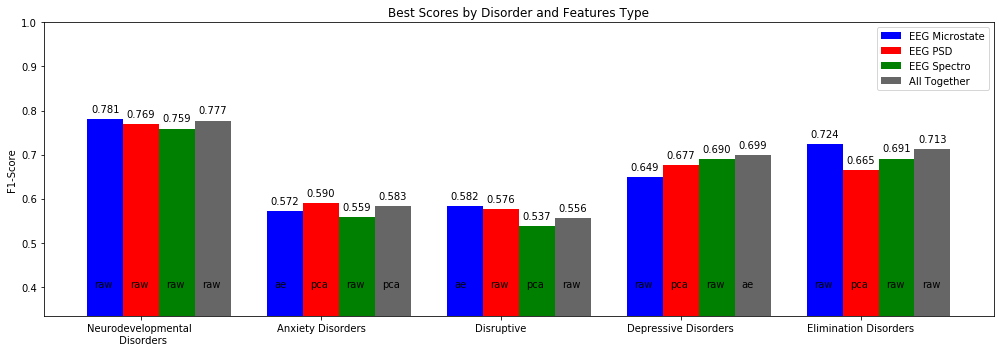

In [376]:
best_micro_=best_per_disorder(results_f1_1,pca_results_f1_1,ae_results_f1_1)
best_psd_=best_per_disorder(results_f1_2,pca_results_f1_2,ae_results_f1_2)
best_spectro_=best_per_disorder(results_f1_3,pca_results_f1_3,ae_results_f1_3)
best_all_together_=best_per_disorder(results_f1_all,pca_results_f1_all,ae_results_f1_all)

best_micro=[value[-1] for _,value in best_micro_.items()]
best_micro_method=[value[0] for _,value in best_micro_.items()]
best_psd=[value[-1] for _,value in best_psd_.items()]
best_psd_method=[value[0] for _,value in best_psd_.items()]
best_spectro=[value[-1] for _,value in best_spectro_.items()]
best_spectro_method=[value[0] for _,value in best_spectro_.items()]
best_all_together=[value[-1] for _,value in best_all_together_.items()]
best_all_together_method=[value[0] for _,value in best_all_together_.items()]

labels=['Neurodevelopmental \n Disorders','Anxiety Disorders','Disruptive','Depressive Disorders','Elimination Disorders']

x = np.arange(len(labels))  # the label locations
width = 1/(4+1)  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 5))
rects1 = ax.bar(x , best_micro, width, label='EEG Microstate',color='b',)
rects2 = ax.bar(x+ width , best_psd, width, label='EEG PSD',color='r')
rects3 = ax.bar(x + 2*width, best_spectro, width, label='EEG Spectro',color='g')
rects4= ax.bar(x + 3*width, best_all_together, width, label='All Together',color='black',alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('F1-Score')
ax.set_title('Best Scores by Disorder and Features Type')
ax.set_xticks(x+width)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects,best):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i,rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width()/2 , height),
                     xytext=(0, 5),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')
        
        ax.annotate('{:}'.format(best[i]),xy=(rect.get_x() + rect.get_width()/2-0.06 , 0.4))



autolabel(rects1,best_micro_method)
autolabel(rects2,best_psd_method)
autolabel(rects3,best_spectro_method)
autolabel(rects4,best_all_together_method)


plt.ylim([np.min(best_all) - (1 - np.min(best_all)) / 2, 1])



fig.tight_layout()


plt.show()


